In [1]:
#Useful imports
#will remain the same
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

np.random.seed(42)
tf.random.set_seed(42)

2024-02-14 21:39:29.017815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 21:39:29.017904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 21:39:29.036257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 21:39:29.069994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 21:39:29.891892: W tensorflow/compiler/tf2

In [ ]:
import os
from PIL import Image

def convert_tif_to_jpeg(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all files in the input folder
    files = os.listdir(input_folder)
    
    # Iterate over each file
    for file in files:
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file)
        
        try:
            # If it's a JPEG file, simply copy it to the output folder
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                with open(input_path, 'rb') as fin, open(output_path, 'wb') as fout:
                    fout.write(fin.read())
                print(f"Copied {file} as JPEG.")
            # If it's a TIFF file, convert it to JPEG
            elif file.endswith('.tif') or file.endswith('.tiff'):
                # Open the TIFF image
                image = Image.open(input_path)
                # Convert and save as JPEG
                jpeg_path = os.path.splitext(output_path)[0] + ".jpeg"
                image.convert("RGB").save(jpeg_path, "JPEG")
                print(f"Converted {file} to JPEG.")
            else:
                print(f"Ignored {file}. It's neither a TIFF nor a JPEG.")
        except Exception as e:
            print(f"Error processing {file}:", e)

# Example usage:
input_folder = "Dataset/Total Images/"
output_folder = "Dataset/Images/"
convert_tif_to_jpeg(input_folder, output_folder)

In [65]:
filenames_img=sorted(os.listdir('Dataset/Images'))
filenames_gt=sorted(os.listdir('Dataset/Total GT'))
filenames_imgsplit=[filename.replace('.jpeg', '').replace('.jpg', '')  for filename in filenames_img]
filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

5160
5160


In [66]:
#train test validate splitting
split_idx = int(0.8 * len(filenames_imgsplit))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
validation_samples_split = test_samples_split[:val_split_idx]
test_samples = test_samples[val_split_idx:]
test_samples_split = test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f' Example from training dataset {train_samples_split[0]}')

Total training samples: 4128
Total validation samples: 516
Total test samples: 516
 Example from training dataset AHTD3A0003_Para1_1_word1


In [67]:
#get data and labels as lists
base_path='Dataset/'
base_image_path = os.path.join(base_path, "Images/")
base_GT_path = os.path.join(base_path, "Total GT/")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_GT_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r") 
        labels.append(label_file.read())

    return paths, labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

In [68]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  7
Vocab size:  39


['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م']

In [69]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [70]:
print(characters)

{'،', 'ح', 'ج', 'م', 'ق', 'ئ', 'ؤ', 'ف', 'ا', 'ة', 'ع', 'و', 'ش', 'ر', 'د', 'ء', '.', 'أ', 'ذ', 'ك', 'ث', 'ن', 'ظ', 'ص', 'ب', 'ه', 'ز', 'ي', 'س', 'ت', 'ط', 'غ', 'ٍ', 'خ', 'ض', 'آ', 'إ', 'ل', ':'}


In [71]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [72]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [73]:
print(train_labels_cleaned)

['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'بد', 'مظفر', 'نوح', 'ذهب', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'وهلال', 'عطعوط', 'وهو', 'و', 'طفنا', 'لنا', 'وصو', 'عند', '.', 'يلبي', 'آخر', 'ثر', 'إ', 'حاج', 'في', 'جاري', 'كان', '.', 'شيخ', 'مع', 'سعينا', '.', 'رايق', 'ي', 'لؤ', 'بن', '.', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'مظفر', 'للحج', 'نوح', 'هب', 'ذ', 'عفيف', 'خازن', 'ل', 'وهلا', 'عطعوط', 'فر', 'ظا', 'الخيمة', 'وصولنا', 'عند', '.', 'يلبي', 'آخر', 'إ', 'حاج', 'لحجيج', 'ا', 'قوافل', 'في', 'أت', 'بد', 'جاري', 'كان', '.', 'شيخ', 'مع', 'وسعينا', 'طفنا', '.', 'دراق', '،', 'مشمش', ':', 'لنص', 'ا', 'ا', 'لهذ', 'نسر', '،', 'بث', '،', 'ناء', '،', 'غيظ', '،', '.', 'نسر', '،', 'بث', '،', 'ء', 'نا', '،', 'غيظ', 'ط', 'و', 'ؤ', 'ر', '.', '.', 'بصحبة', 'م', 'غا', 'ضر', 'عطعو', 'مظفر', 'ح', 'نو', 'هب', 'ذ', 'ظافر', 'يق', 'ا', 'ر', 'ء', 'لؤ', 'بن', 'ت', 'أ', 'بد', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'ل', 'هلا', 'إ', 'ج', 'حا', 'لحجيج', 'أ', 'فل', 'ا', 'قو', 'سعينا', 'و', 'طفنا', 'ل

In [74]:
batch_size = 64
padding_token = 99
image_width = 64
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 0)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label
    
label=vectorize_label(train_labels_cleaned[0])
print(label)
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")
print(label)

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

أت
tf.Tensor([18 30 99 99 99 99 99], shape=(7,), dtype=int64)
أت


In [75]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


2024-02-14 22:07:27.822358: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


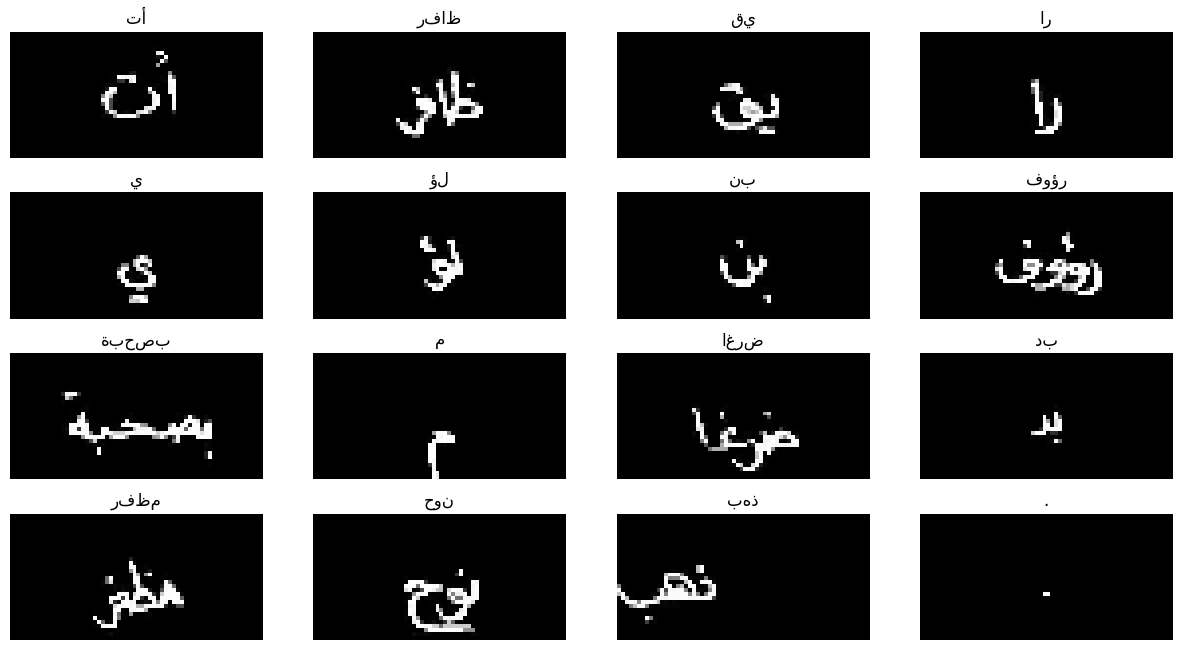

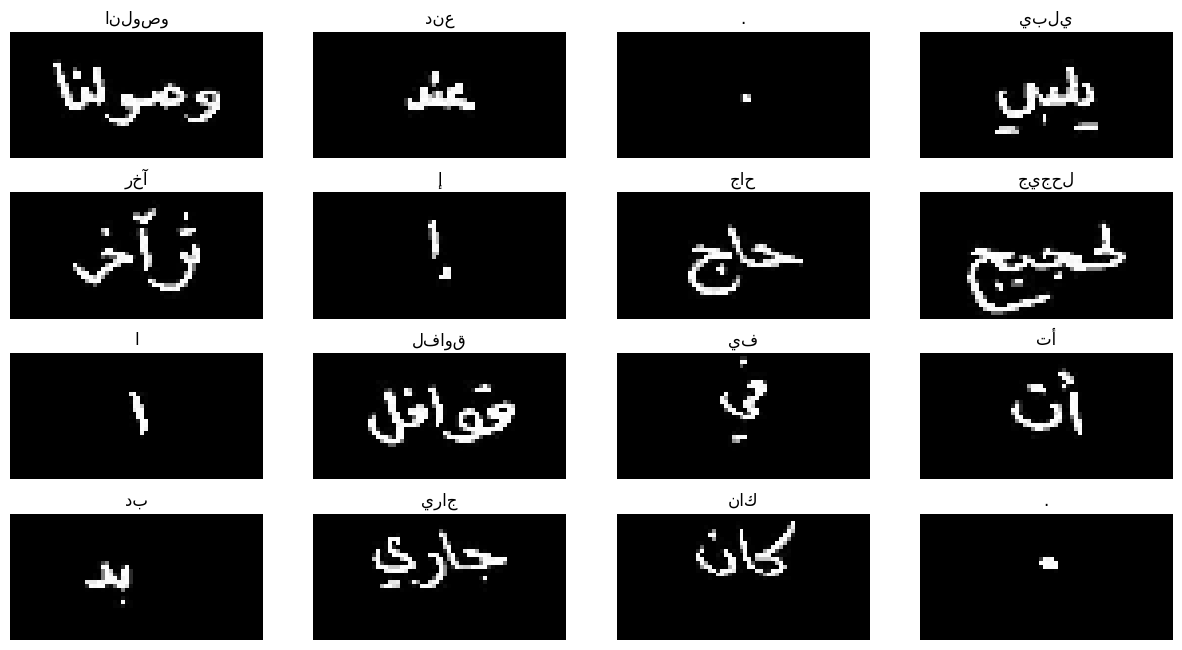

In [76]:
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1])
        ax[i // 4, i % 4].axis("off")


plt.show()

In [77]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= keras.layers.BatchNormalization()(x)
    new_shape = ((image_width // 2), (image_height // 2) * 32)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(16, activation="relu", name="dense2")(x)
    x= keras.layers.BatchNormalization()(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 64, 32, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 32, 32)           320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 32, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 batch_normalization_2 (Bat  (None, 32, 16, 32)           128       ['pool1[0][0]']               
 chNormalization)                                                            

In [78]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [79]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.sparse.from_dense(labels)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = keras.backend.ctc_decode(
        
        predictions, input_length=input_len, greedy=False, beam_width=100,
    )[0][0][:, :max_len]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)
    
    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [80]:


epochs = 20  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
)

#add early stopping mechanism

Epoch 1/20


2024-02-14 22:08:13.118100: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 22:08:13.132740: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : INTERNAL: Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(4837): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
2024-02-14 22:08:13.132798: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15708046444543837809
2024-02-14 22:08:13.132809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5201733613951478193
2024-02-14 22:08:13.132817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9396258363242773399
2024-02-14 22:08:13.132824: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled

InternalError: Graph execution error:

Detected at node handwriting_recognizer/Conv1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_31655/3582739909.py", line 20, in <module>

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

Detected at node handwriting_recognizer/Conv1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_31655/3582739909.py", line 20, in <module>

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/idriss/.local/share/virtualenvs/Arabic-Handwritten-OCR-WxdVCjLx/lib/python3.11/site-packages/keras/src/backend.py", line 5395, in relu

2 root error(s) found.
  (0) INTERNAL:  Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(4837): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node handwriting_recognizer/Conv1/Relu}}]]
	 [[handwriting_recognizer/ctc_loss/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_int32_Squeeze_1/_88]]
  (1) INTERNAL:  Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(4837): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node handwriting_recognizer/Conv1/Relu}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_13087]

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    return output_text

['نا', 'لط', 'ل', '.', 'حج', 'ا', 'وف', 'و', 'نا', 'ل', 'ر', 'م', 'ر', 'ا', 'نا', 'ا', 'ا', 'ل', 'بة', 'ا', 'ل', 'ي', 'نا', 'حجية', 'ا', 'ل', 'ا', 'ق', 'ر', 'ا', 'ل', 'د', '،', 'حج', 'وف', 'ن', 'ن', 'و', 'ير', 'ر', 'ا', 'ر', 'أ', 'نا', 'ي', 'فر', 'ل', 'نا', '.', 'حيج', 'ي', 'نا', '،', 'نا', 'د', 'م', 'نا', 'ي', 'نا', 'يف', 'يم', 'ية', 'ا', 'ي']
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


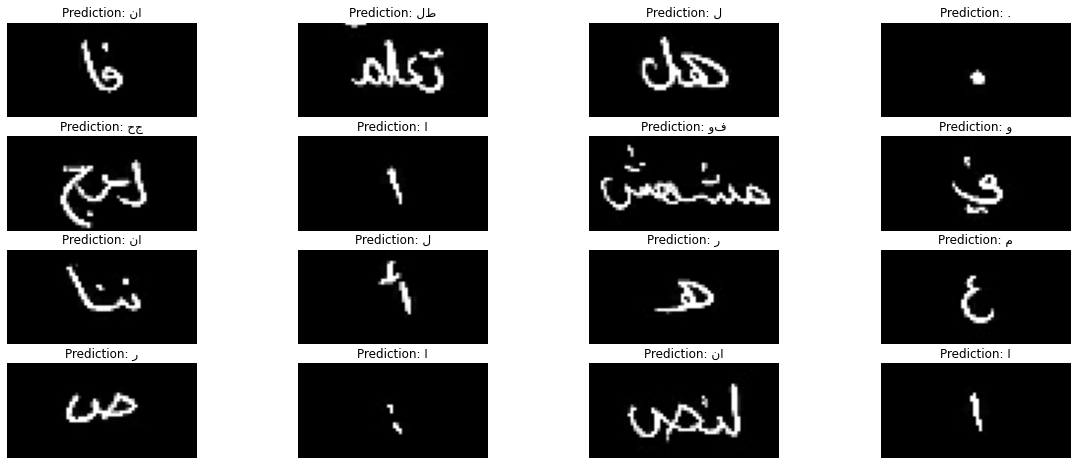

In [ ]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        print(pred_texts[i]=='')
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

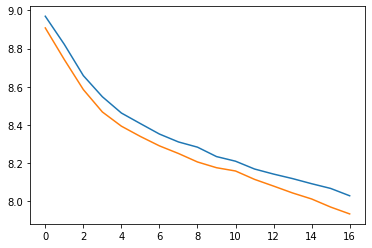

In [ ]:
plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][2:len(history.history['loss'])-1])

In [ ]:
plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][1:len(history.history['loss'])-1])

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])